# LaQuacco

## Laboratory Quality Control

### Module Imports

In [12]:
import multiprocessing
import os
import platform
import matplotlib.pyplot as plt
import numpy as np
import tkinter.filedialog as tkf

### User Input

In [2]:
# define number of concurrent workers
processes = multiprocessing.cpu_count() // 2 or 1

# define relative samples size for normalization
sample_perc = 10

# define directory and extension of data files
file_types = [("All files", "*.*"),
              ("OME-TIFF", "*.ome.tif?"),
              ("Vectra QPTIFF", "*.qptiff"),
              ("Tag Image File Format", "*.tif?"),
              ]
open_file_name = os.path.abspath(tkf.askopenfilename(title="Select an image in your data folder", filetypes=file_types))
data_dir = os.path.dirname(open_file_name)
data_ext = "*" + os.path.splitext(open_file_name)[1]

### Main Program

In [3]:
import definitions as defs  # make functions visible in `__main__`

if __name__ == "__main__":

    # safe import of main module avoids spawning multiple processes simultaneously
    if platform.system() == "Windows":
        multiprocessing.freeze_support()  # required by 'multiprocessing'

    # get a list of all image files
    files = sorted(
        defs.get_files(
            # path=r"C:\Users\Christian Rickert\Desktop\Polaris",
            path=data_dir,
            pat=data_ext,
            anti="",
        ),
        key=str.lower,
    )

    # sample experimental image data
    try:
        samples = sorted(defs.get_samples(population=files, perc=10), key=str.lower)
        sample_args = [(sample, None) for sample in samples]
    except ValueError:
        print("Could not draw samples from experimental population.")
        sys.exit(1)

    # analyze the sample data
    with multiprocessing.Pool(processes) as pool:
        sample_results = pool.starmap(defs.read_img_data, sample_args)
        pool.close()  # wait for worker tasks to complete
        pool.join()  # wait for worker process to exit
    samples_img_data = {sample: img_data for (sample, img_data) in sample_results}

    chans_set = set()  # avoid duplicate entries
    for img_data in samples_img_data.values():
        for chan in img_data:
            if chan not in ["metadata"]:
                chans_set.add(chan)
    chans = sorted(chans_set, key=str.lower)

    # prepare colormap
    color_map = defs.get_colormap(len(chans))

    # prepare lambdas for power transform
    chan_lmbdas = {}
    for chan in chans:
        chan_data = defs.get_chan_data(samples_img_data, chan, "chan_lmbda")
        chan_mean = defs.get_mean(chan_data)
        chan_lmbdas[chan] = chan_mean

    # analyze experimental image data
    image_args = [(image, chan_lmbdas) for image in files]
    with multiprocessing.Pool(processes) as pool:
        image_results = pool.starmap(defs.read_img_data, image_args)
        pool.close()  # wait for worker tasks to complete
        pool.join()  # wait for worker process to exit
    images_img_data = {image: img_data for (image, img_data) in image_results}

    # sort experimental image data by time stamp
    images_img_data = dict(
        sorted(images_img_data.items(), key=lambda v: v[1]["metadata"]["date_time"])
    )

### Plot data

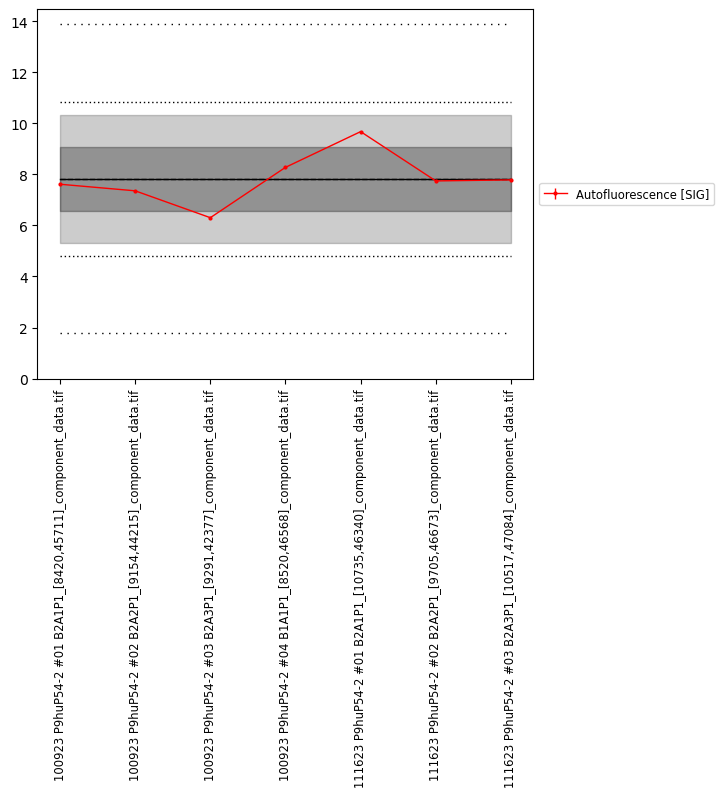

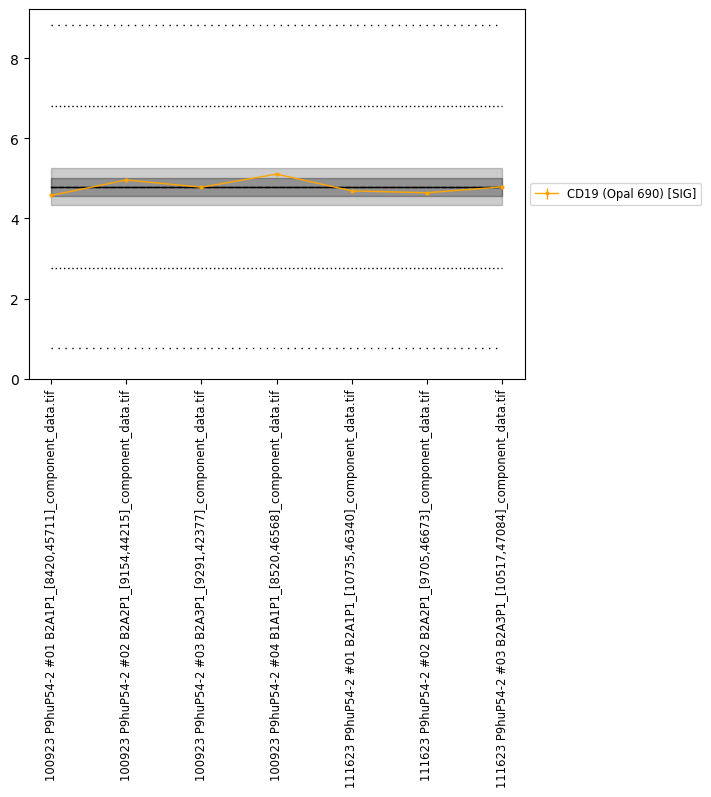

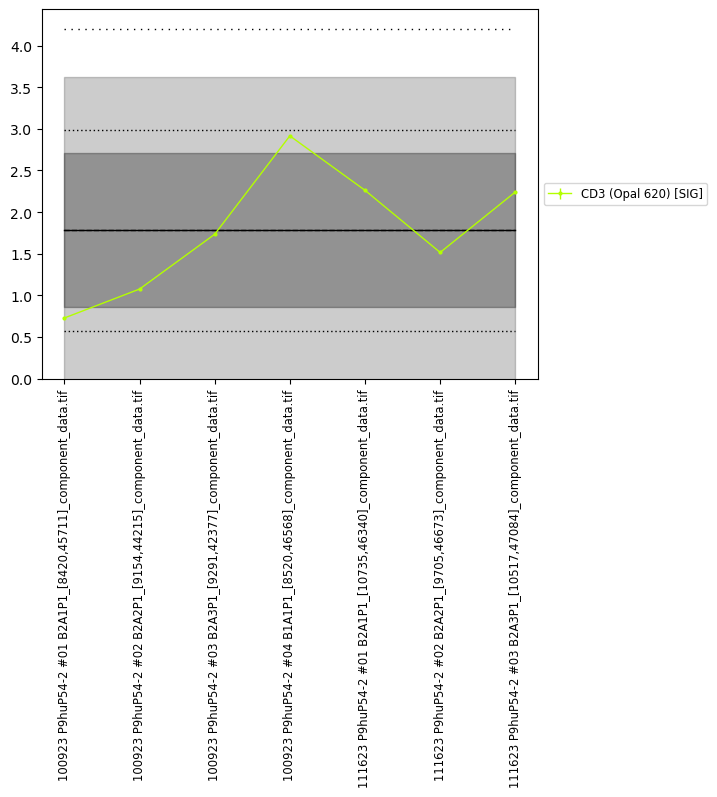

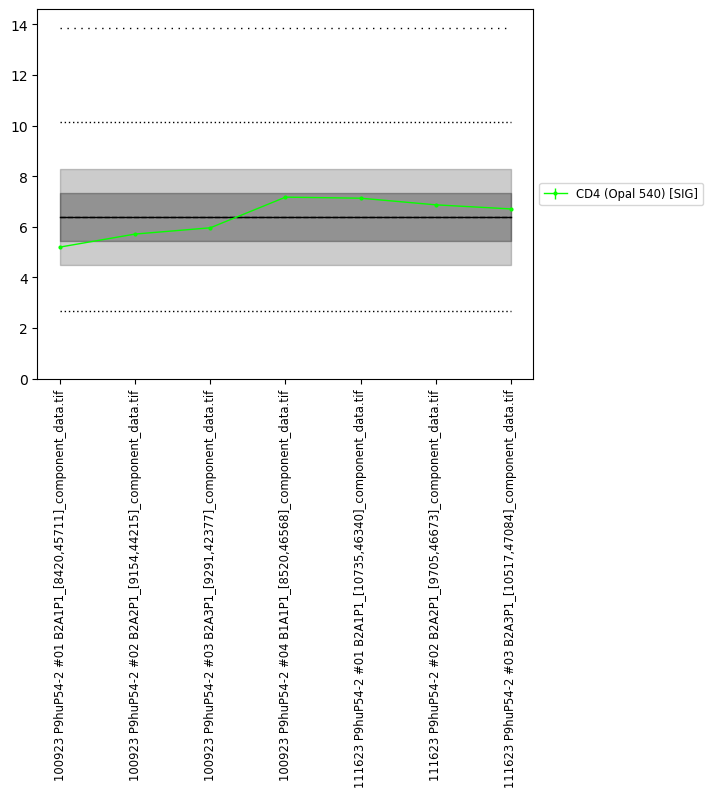

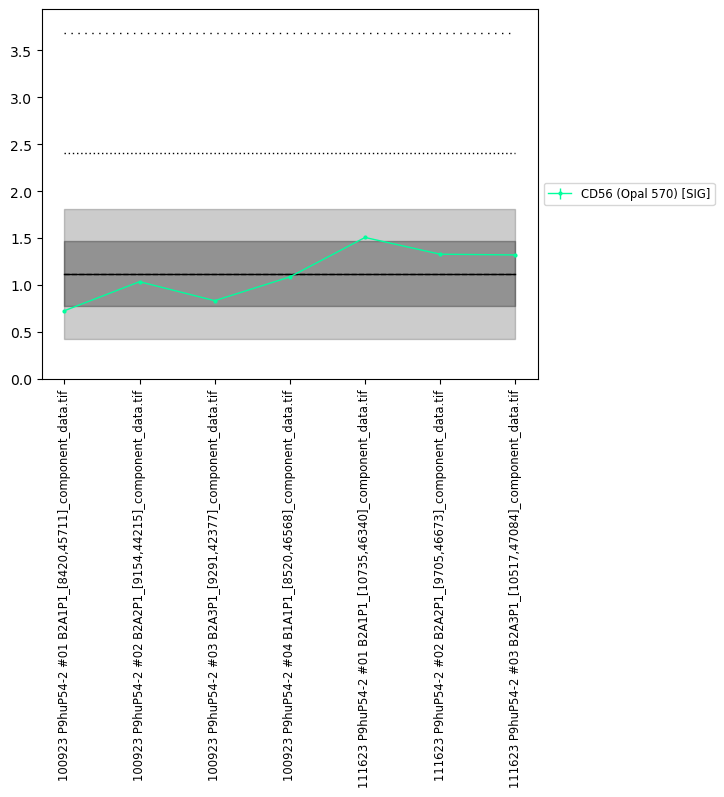

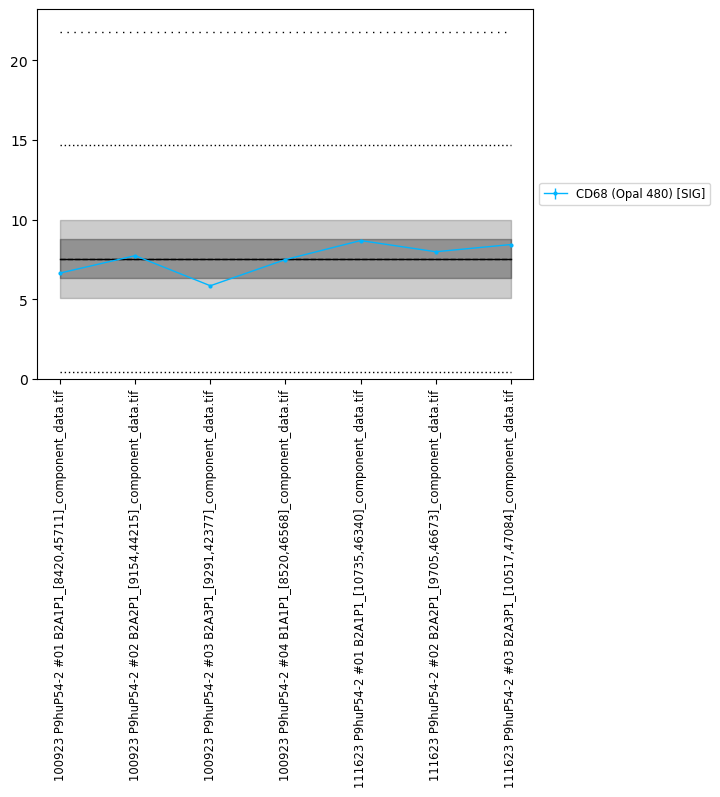

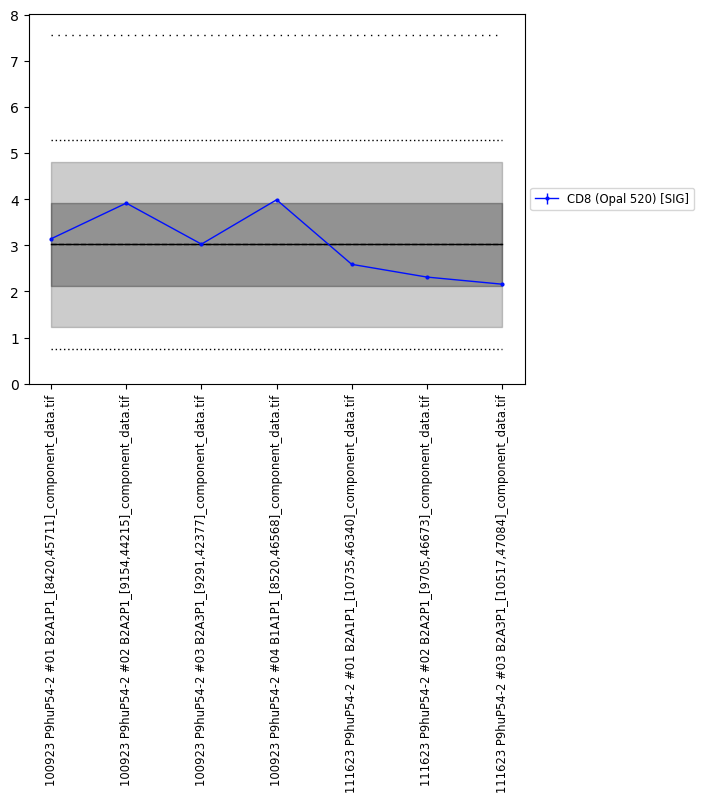

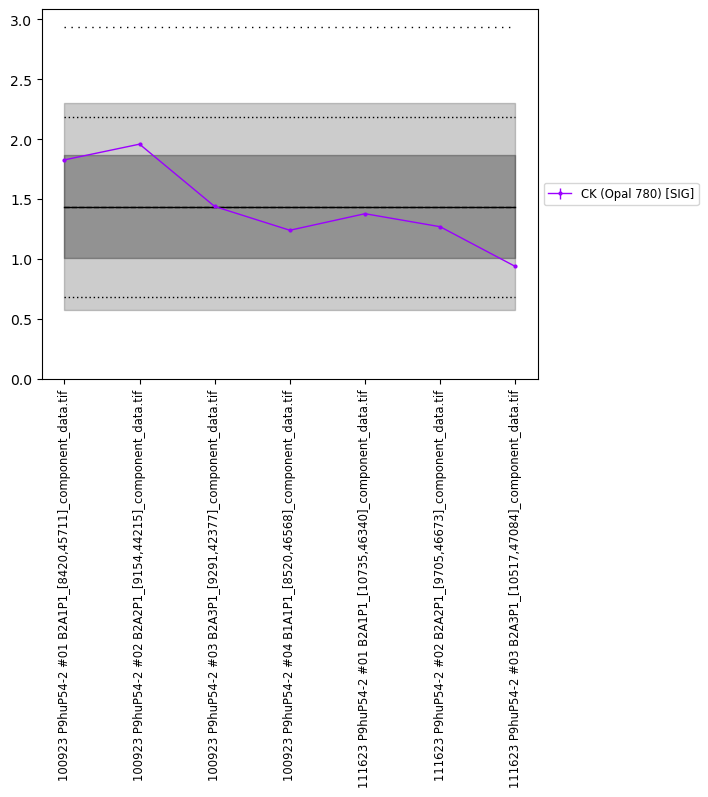

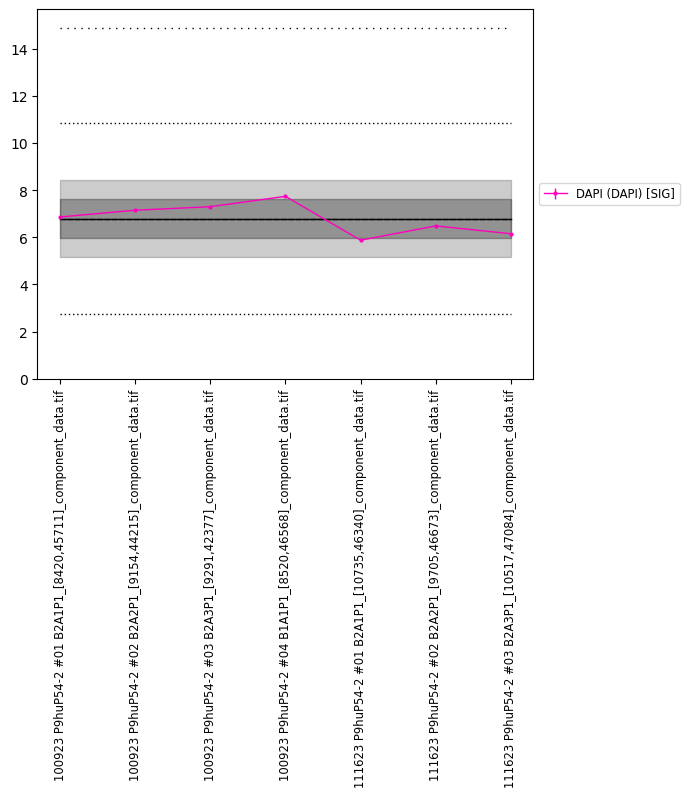

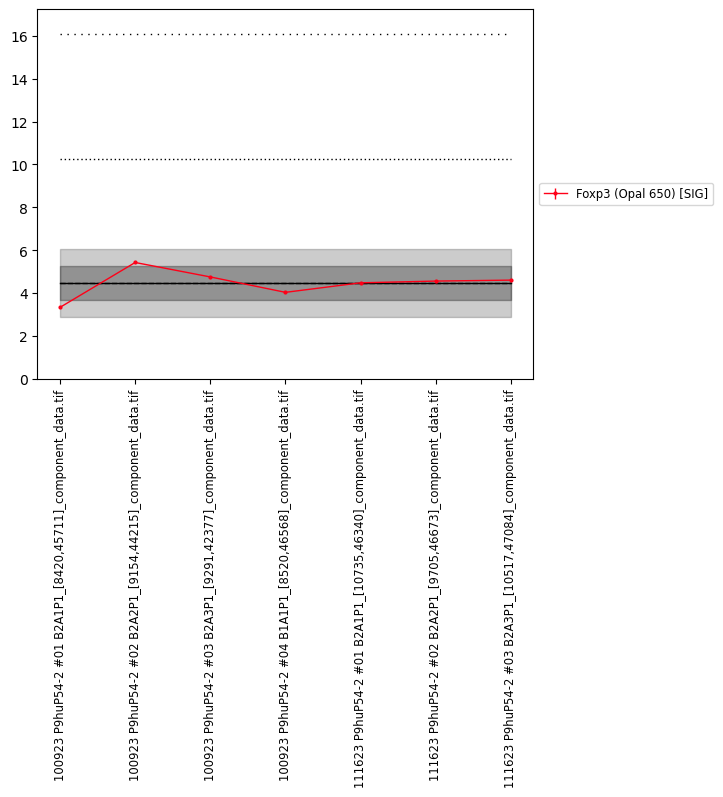

<Figure size 640x480 with 0 Axes>

In [13]:
    # Levey-Jennings chart
    signal_labels = [os.path.basename(image) for image in images_img_data.keys()]
    slice_margin = len(files) - 1  # extend slice to either sides
    slice_min = False  # don't show data for incomplete slices
    fit_trend = False  # fit a linear regression model of the mean
    slice_size = 2 * slice_margin + 1
    assert (
        slice_size > 3
    ), "Zero degrees of freedom to estimate the standard deviation from the trend line."
    file_len = len(files)
    xs = range(0, file_len)
    np_nan = np.full(file_len, np.nan)
    for c, chan in enumerate(chans):
        # prepare variables
        trend_stats = {stat: np_nan.copy() for stat in ["vals", "stdevs", "where"]}
        run_stats = {stat: np_nan.copy() for stat in ["slice", "means", "stdevs"]}
        # get image statistics
        signal_means = defs.get_chan_data(images_img_data, chan, "sign_mean")
        signal_stdevs = defs.get_chan_data(images_img_data, chan, "sign_stdev")
        signal_stderrs = defs.get_chan_data(images_img_data, chan, "sign_stderr")
        # get trend statistics
        if fit_trend:
            slope, inter = np.polyfit(xs, signal_means, deg=1)
            trend_stats["vals"] = slope * xs + inter
        else:
            trend_stats["vals"].fill(defs.get_mean(signal_means))
        # get running statistics
        for i, mean in enumerate(signal_means):
            run_stats["slice"] = defs.get_run_slice(signal_means, i, slice_margin, slice_min)
            if not slice_min or run_stats["slice"].size == slice_size:
                run_stats["means"][i] = defs.get_mean(run_stats["slice"])
                run_stats["stdevs"][i] = defs.get_mean(
                    defs.get_run_slice(signal_stdevs, i, slice_margin, slice_min)
                )
                trend_stats["stdevs"][i] = defs.get_stdev(
                    run_stats["slice"],
                    defs.get_mean(
                        defs.get_run_slice(trend_stats["vals"], i, slice_margin, slice_min)
                    ),
                    ddof=3,  # estimated: slope, intercept, and mean
                )
        if not slice_min:
            # fill `stdevs` array with limit values
            trend_stats["where"] = np.where(~np.isnan(trend_stats["stdevs"]))[0]
            if trend_stats["where"].size > 0:  # channel might be sparse with images
                trend_stats["stdevs"][: trend_stats["where"][0]] = trend_stats[
                    "stdevs"
                ][
                    trend_stats["where"][0]
                ]  # extend left
                trend_stats["stdevs"][trend_stats["where"][-1] :] = trend_stats[
                    "stdevs"
                ][
                    trend_stats["where"][-1]
                ]  # extend right
        # plot statistics
        for dist in [2.0, 1.0, -1.0, -2.0]:
            linestyle = (0, (1, 2))
            if abs(dist) == 2.0:
                linestyle = linestyle = (0, (1, 4))
            plt.plot(
                run_stats["means"] + dist * run_stats["stdevs"],
                color="black",
                linewidth=1,
                linestyle=linestyle,
            )
        for dist in [2.0, 1.0]:
            alpha = 0.2
            if abs(dist) == 1.0:
                alpha = 0.1
            plt.fill_between(
                xs,
                trend_stats["vals"] + dist * trend_stats["stdevs"],
                trend_stats["vals"] - dist * trend_stats["stdevs"],
                color="black",
                alpha=alpha,
            )
        plt.fill_between(
            xs,
            trend_stats["vals"] + 1.0 * trend_stats["stdevs"],
            trend_stats["vals"] - 1.0 * trend_stats["stdevs"],
            color="black",
            alpha=0.2,
        )
        plt.plot(trend_stats["vals"], color="black", linewidth=1, linestyle="solid")
        plt.plot(run_stats["means"], color="black", linewidth=1, linestyle="dashed")
        plt.errorbar(
            signal_labels,
            signal_means,
            yerr=signal_stderrs,
            fmt="o-",
            linewidth=1,
            markersize=2,
            color=color_map[c],
            label=chan + " [SIG]",
        )
        legend = plt.legend(
            loc="center left", bbox_to_anchor=(1, 0.5), fontsize="small"
        )
        plt.xticks(rotation=90, fontsize="small")
        plt.ylim(bottom=0.0)
        plt.show()
        plt.clf()